## Building Advanced Transformers

- Implement advanced Transformer models using Keras. 

- Apply Transformers to real-world sequential data tasks. 

- Build, train, and evaluate Transformer models. 

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import requests
from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

In [2]:
import numpy as np
import pandas as pd

# Create a synthetic stock price dataset
np.random.seed(42)
data_length = 2000  # Adjust data length as needed
trend = np.linspace(100, 200, data_length)
noise = np.random.normal(0, 2, data_length)
synthetic_data = trend + noise

# Create a DataFrame and save as 'stock_prices.csv'
data = pd.DataFrame(synthetic_data, columns=['Close'])
data.to_csv('stock_prices.csv', index=False)
print("Synthetic stock_prices.csv created and loaded.")

Synthetic stock_prices.csv created and loaded.


In [3]:
# Load the dataset 
data = pd.read_csv('stock_prices.csv') 
data = data[['Close']].values 

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Prepare the data for training
def create_dataset(data, time_step=1):
    X, Y = [], []

    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X, Y = create_dataset(data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape) 

Shape of X: (1899, 100, 1)
Shape of Y: (1899,)


In [4]:
class MultiHeadSelfAttention(Layer): 

    def __init__(self, embed_dim, num_heads=8): 
        super(MultiHeadSelfAttention, self).__init__() 
        self.embed_dim = embed_dim 
        self.num_heads = num_heads 
        self.projection_dim = embed_dim // num_heads 
        self.query_dense = Dense(embed_dim) 
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim) 
        self.combine_heads = Dense(embed_dim) 


    def attention(self, query, key, value): 
        score = tf.matmul(query, key, transpose_b=True) 
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) 
        scaled_score = score / tf.math.sqrt(dim_key) 
        weights = tf.nn.softmax(scaled_score, axis=-1) 
        output = tf.matmul(weights, value) 
        return output, weights 

    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) 

    def call(self, inputs): 
        batch_size = tf.shape(inputs)[0] 
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs) 
        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 
        attention, _ = self.attention(query, key, value) 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim)) 
        output = self.combine_heads(concat_attention) 
        return output 


In [5]:
class TransformerBlock(Layer): 

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerBlock, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 


    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 

      Input
        │
        ▼
  ┌────────────────────┐
  │ Multi-Head Attention│
  └────────────────────┘
        │
     Dropout
        ▼
Residual Add + LayerNorm
        ▼
  ┌────────────────────┐
  │ Feed Forward Network│
  └────────────────────┘
        │
     Dropout
        ▼
Residual Add + LayerNorm
        ▼
     Output


In [6]:
class EncoderLayer(Layer): 

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(EncoderLayer, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 

 

    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 


### Implement Transformer encoder

In [8]:
import tensorflow as tf 
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout 

class MultiHeadSelfAttention(Layer): 
    def __init__(self, embed_dim, num_heads=8): 
        super(MultiHeadSelfAttention, self).__init__() 
        self.embed_dim = embed_dim 
        self.num_heads = num_heads 
        self.projection_dim = embed_dim // num_heads 
        self.query_dense = Dense(embed_dim) 
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim) 
        self.combine_heads = Dense(embed_dim) 
 

    def attention(self, query, key, value): 
        score = tf.matmul(query, key, transpose_b=True) 
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) 
        scaled_score = score / tf.math.sqrt(dim_key) 
        weights = tf.nn.softmax(scaled_score, axis=-1) 
        output = tf.matmul(weights, value) 
        return output, weights 


    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) 


    def call(self, inputs): 
        batch_size = tf.shape(inputs)[0] 
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs) 
        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 
        attention, _ = self.attention(query, key, value) 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim)) 
        output = self.combine_heads(concat_attention) 
        return output 

class TransformerBlock(Layer): 
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerBlock, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 
 

    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 

class TransformerEncoder(Layer): 
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerEncoder, self).__init__() 
        self.num_layers = num_layers 
        self.embed_dim = embed_dim 
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)] 
        self.dropout = Dropout(rate) 

    def call(self, inputs, training=False): 
        x = inputs 
        for i in range(self.num_layers): 
            x = self.enc_layers[i](x, training=training) 
        return x 

# Example usage 
embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 
inputs = tf.random.uniform((1, 100, embed_dim)) 
outputs = transformer_encoder(inputs, training=False)  # Use keyword argument for 'training' 
print(outputs.shape)  # Should print (1, 100, 128) 

(1, 100, 128)


### Build and Compile the Transformer model

In [9]:
# Define the necessary parameters 

embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

# Define the Transformer Encoder 
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 

# Build the model 
input_shape = (X.shape[1], X.shape[2]) 
inputs = tf.keras.Input(shape=input_shape) 

# Project the inputs to the embed_dim 
x = tf.keras.layers.Dense(embed_dim)(inputs) 
encoder_outputs = transformer_encoder(x) 
flatten = tf.keras.layers.Flatten()(encoder_outputs) 
outputs = tf.keras.layers.Dense(1)(flatten) 
model = tf.keras.Model(inputs, outputs) 

# Compile the model 
model.compile(optimizer='adam', loss='mse') 

# Summary of the model 
model.summary() 

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 100, 128)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 100, 128)       │       793,088 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - loss: 11.6558
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - loss: 0.2082
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - loss: 0.2082
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - loss: 0.1332
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - loss: 0.1267
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - loss: 0.1280
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - loss: 0.1457
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - loss: 0.1545
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - loss: 0.1593
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - loss: 0.0956
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - loss: 0.1496
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - loss: 0.1252
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - loss: 0.0898
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - loss: 0.0783
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - 

60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step


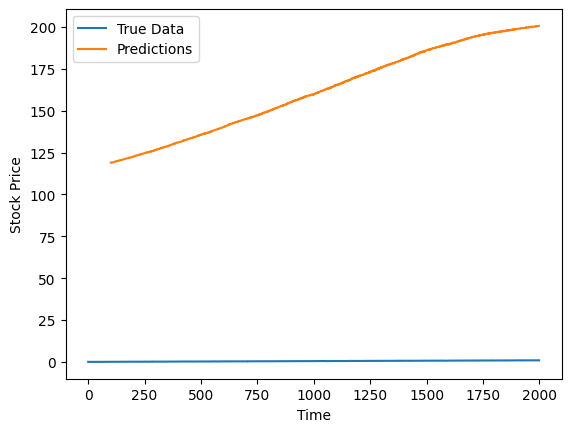

In [11]:
# Make predictions 
predictions = model.predict(X) 
predictions = scaler.inverse_transform(predictions) 
 

# Plot the predictions 
import matplotlib.pyplot as plt 

plt.plot(data, label='True Data') 
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.show() 

#### Add dropout to the Transformer model

In [12]:
from tensorflow.keras.layers import Dropout 

  

# Add a dropout layer after the Flatten layer 

flatten = tf.keras.layers.Flatten()(encoder_outputs) 

dropout = Dropout(0.5)(flatten) 

outputs = tf.keras.layers.Dense(1)(dropout) 

  

# Build the model 

model = tf.keras.Model(inputs, outputs) 

  

# Compile the model 

model.compile(optimizer='adam', loss='mse') 

  

# Train the model 

model.fit(X, Y, epochs=20, batch_size=32) 

  

# Evaluate the model 

loss = model.evaluate(X, Y) 

print(f'Test loss: {loss}') 

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - loss: 8.6165
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - loss: 1.4008
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - loss: 0.9497
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - loss: 0.5888
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - loss: 0.2342
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - loss: 0.0862
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - loss: 0.0538
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - loss: 0.0288
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - loss: 0.0294
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - loss: 0.0308
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - loss: 0.0217
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - loss: 0.0200
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 0.0164
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 0.0166
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/ste

#### Experiment with different batch sizes
- Train the model with a batch size of 16. 

- Train the model with a batch size of 64. 

- Compare the training time and performance. 

In [13]:
# Train the model with batch size 16
model.fit(X, Y, epochs=20, batch_size=16)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 16: {loss}')

# Train the model with batch size 64
model.fit(X, Y, epochs=20, batch_size=64)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 64: {loss}')

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - loss: 0.0193
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - loss: 0.0239
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.0272
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 0.0248
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 0.0256
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - loss: 0.0381
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 0.0193
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 0.0170
Epoch 9/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 0.0170
Epoch 10/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0234
Epoch 11/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 0.0119
Epoch 12/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 0.0227
Epoch 13/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 0.0266
Epoch 14/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.0166
Epoch 15/20
119/119 ━━━━━━━━━

#### Use a different activation function
- Change the activation function of the Dense layer to `tanh`. 

- Train and evaluate the model. 

In [14]:
# Change the activation function of the Dense layer to tanh
outputs = tf.keras.layers.Dense(1, activation='tanh')(flatten)

# Build the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with tanh activation: {loss}')

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - loss: 0.2120
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - loss: 0.0267
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - loss: 0.0091
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - loss: 0.0038
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - loss: 0.0027
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - loss: 0.0021
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - loss: 0.0020
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - loss: 0.0023
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - loss: 0.0027
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - loss: 0.0019
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - loss: 0.0018
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - loss: 0.0021
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - loss: 0.0022
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - loss: 0.0018
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - l